In [11]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from vmtk import pypes
from vmtk import vmtkscripts

base_dir = os.path.abspath('/media/tianyi/data/Analysis/DCM2BIDS5/')
segmentation_dir = os.path.join(base_dir, 'derivatives', 'manualwork', 'segmentations', 'veins_superficial')
output_dir = os.path.join(base_dir, 'derivatives', 'manualwork', 'vmtk_superficial-veins')


fn_pattern = 'sub-15_superficial-cortical-veins'

In [14]:
input_nii = os.path.join(segmentation_dir, fn_pattern + '_Segmentation-label.nii')

# vmtk: surface extraction
inSurfaceXtrct = input_nii
passband = 0.15
outSurfaceXtrct = os.path.join(output_dir, fn_pattern + '_surface.vtp')
cmdSurfaceXtrct = 'vmtkmarchingcubes -ifile {} -l 0.1 --pipe vmtksurfacesmoothing -passband {} -iterations 30 -ofile {} --pipe vmtksurfaceviewer'.format(inSurfaceXtrct,passband,outSurfaceXtrct)  # input filtered artery
pypes.PypeRun(cmdSurfaceXtrct)

# vmtk: vessel clipping
inClipper = outSurfaceXtrct
outClipper = os.path.join(output_dir, fn_pattern + '_openended.vtp')

if not os.path.exists(outClipper):
	cmdClipper = 'vmtksurfaceclipper -ifile {} -ofile {}'.format(inClipper,outClipper)
	pypes.PypeRun(cmdClipper)



Automatic piping vmtkmarchingcubes
Parsing options vmtkmarchingcubes
    ImageInputFileName = /media/tianyi/data/Analysis/DCM2BIDS5/derivatives/manualwork/segmentations/veins_superficial/sub-15_superficial-cortical-veins_Segmentation-label.nii
    Level = 0.1
Explicit piping vmtkmarchingcubes
Input vmtkmarchingcubes members:
    Id = 0
    Disabled = 0
    Image = None
    ImageInputFileName = /media/tianyi/data/Analysis/DCM2BIDS5/derivatives/manualwork/segmentations/veins_superficial/sub-15_superficial-cortical-veins_Segmentation-label.nii
    ArrayName = 
    Level = 0.1
    Connectivity = 0
    SurfaceOutputFileName = 
Spacing 1.000000 1.000000 1.000000
Origin -127.000000 -127.500000 -127.000000
Dimensions 256 256 256
Executing vmtkmarchingcubes ...
Done executing vmtkmarchingcubes.
Output vmtkmarchingcubes members:
    Id = 0
    Surface = vtkPolyData

Automatic piping vmtksurfacesmoothing
    Surface = vmtkmarchingcubes-0.Surface
Parsing options vmtksurfacesmoothing
    NumberOfI

In [15]:

# vmtk: centerline extraction
# Uncomment the two lines below and comment current working two to compute centerline using manual selection
inCenterline = outClipper
#inCenterline = outSurfaceXtrct
outCenterline = os.path.join(output_dir, fn_pattern + '_centerlines.vtp')
#cmdCenterline = "vmtksurfacereader -ifile {} --pipe vmtkcenterlines -seedselector openprofiles --pipe vmtkrenderer --pipe vmtksurfaceviewer -opacity 0.25 --pipe vmtksurfaceviewer -i @vmtkcenterlines.o -array DistanceToCenterlines -ofile {}".format(inCenterline,outCenterline)
cmdCenterline = 'vmtksurfacereader -ifile {} --pipe vmtkcenterlines --pipe vmtkrenderer --pipe vmtksurfaceviewer -opacity 0.25 --pipe vmtksurfaceviewer -i @vmtkcenterlines.o -array DistanceToCenterlines -ofile {}'.format(inCenterline,outCenterline)
pypes.PypeRun(cmdCenterline)



Automatic piping vmtksurfacereader
Parsing options vmtksurfacereader
    InputFileName = /media/tianyi/data/Analysis/DCM2BIDS5/derivatives/manualwork/vmtk_superficial-veins/sub-15_superficial-cortical-veins_openended.vtp
Explicit piping vmtksurfacereader
Input vmtksurfacereader members:
    Id = 0
    Disabled = 0
    Format = 
    GuessFormat = 1
    Surface = 0
    InputFileName = /media/tianyi/data/Analysis/DCM2BIDS5/derivatives/manualwork/vmtk_superficial-veins/sub-15_superficial-cortical-veins_openended.vtp
    SurfaceOutputFileName = 
Executing vmtksurfacereader ...
Reading VTK XML surface file.
Done executing vmtksurfacereader.
Output vmtksurfacereader members:
    Id = 0
    Surface = vtkPolyData

Automatic piping vmtkcenterlines
    Surface = vmtksurfacereader-0.Surface
Parsing options vmtkcenterlines
Explicit piping vmtkcenterlines
Input vmtkcenterlines members:
    Id = 0
    Disabled = 0
    Surface = vtkPolyData
    SurfaceInputFileName = 
    SeedSelectorName = pickpoint

In [20]:

# centerline reading
centerlineReader = vmtkscripts.vmtkSurfaceReader()
centerlineReader.InputFileName = outCenterline
centerlineReader.Execute()
clNumpyAdaptor = vmtkscripts.vmtkCenterlinesToNumpy()
clNumpyAdaptor.Centerlines = centerlineReader.Surface
clNumpyAdaptor.Execute()
numpyCenterlines = clNumpyAdaptor.ArrayDict

points = numpyCenterlines['Points']
pointsIds = np.arange(len(points))
radius = numpyCenterlines['PointData']['MaximumInscribedSphereRadius']
segPointIds = numpyCenterlines['CellData']['CellPointIds']
numSegments = len(segPointIds)

frames = []
for segId in range(numSegments):
    segment = segPointIds[segId]
    segData = pd.DataFrame({'pointId':segment,'segId':segId*np.ones(len(segment), dtype=int),'x':points[segment,0],'y':points[segment,1],'z':points[segment,2],'radius':radius[segment]})
    frames.append(segData)    
CenterlineData = pd.concat(frames)


for segId in range(numSegments):
    segment = CenterlineData[CenterlineData['segId'] == segId]
    
    x = np.array(segment['x'])
    y = np.array(segment['y'])
    z = np.array(segment['z'])
    
    diff_x = np.diff(x)
    diff_y = np.diff(y)
    diff_z = np.diff(z)

    steplength = np.sqrt(np.square(diff_x) + np.square(diff_y) + np.square(diff_z))
    distance = np.cumsum(steplength)
    distance = np.insert(distance,0,0)
    
    CenterlineData.loc[CenterlineData['segId'] == segId, 'distance'] = distance

CenterlineData['diameter'] = 2 * CenterlineData['radius']

#outDataframe = vmtkfolder + "sub-{}_".format(num) + "artery-clData.csv"
#CenterlineData.to_csv(outDataframe,index=False)

Reading VTK XML surface file.
wrapping vtkPolyData object
converting cell data: 
converting points
converting point data: 
MaximumInscribedSphereRadius
EdgeArray
EdgePCoordArray
converting cell connectivity list


In [26]:
CenterlineData[CenterlineData['segId']==1]

,pointId,segId,x,y,z,radius,distance,diameter
0,1932,1,7.473295,70.492523,49.438602,1.692917,0.000000,3.385835
1,1931,1,7.472724,70.456032,49.469170,1.702810,0.047606,3.405620
2,1930,1,7.472713,70.455284,49.469795,1.703012,0.048581,3.406023
3,1929,1,7.477820,70.374130,49.582939,1.710494,0.187913,3.420988
4,1928,1,7.538677,69.682068,50.419952,1.646069,1.275684,3.292137
...,...,...,...,...,...,...,...,...
1007,925,1,-51.462685,-2.751127,-34.851280,2.755363,358.158783,5.510725
1008,924,1,-51.214787,-2.574397,-35.113842,2.780938,358.560822,5.561877
1009,923,1,-51.202499,-2.564206,-35.126816,2.782248,358.581390,5.564496
1010,922,1,-50.765930,-2.327535,-35.514759,2.819289,359.211548,5.638577


In [17]:
points

array([[ 55.649292, -17.506832, -14.395976],
       [ 55.650726, -17.518269, -14.395362],
       [ 55.707703, -17.781204, -14.392217],
       ...,
       [ 13.361275,  68.82599 ,  72.699745],
       [ 13.382085,  69.02797 ,  72.47324 ],
       [ 13.317464,  69.31712 ,  72.09046 ]], dtype=float32)

     pointId  segId          x          y          z    radius
0        912      0  13.317464  69.317123  72.090462  1.205604
1        911      0  13.382085  69.027969  72.473244  1.533681
2        910      0  13.361275  68.825989  72.699745  1.687721
3        909      0  13.390991  68.748322  72.967232  1.751892
4        908      0  13.402751  68.725067  73.032600  1.766615
..       ...    ...        ...        ...        ...       ...
938      917      1 -53.526131 -10.175121  -7.860950  2.988495
939      916      1 -53.457897  -9.698871  -7.880874  2.762811
940      915      1 -53.457085  -9.474609  -7.875126  2.648384
941      914      1 -53.460148  -9.451494  -7.878831  2.634406
942      913      1 -53.460224  -9.450926  -7.878922  2.634063

[1856 rows x 6 columns]


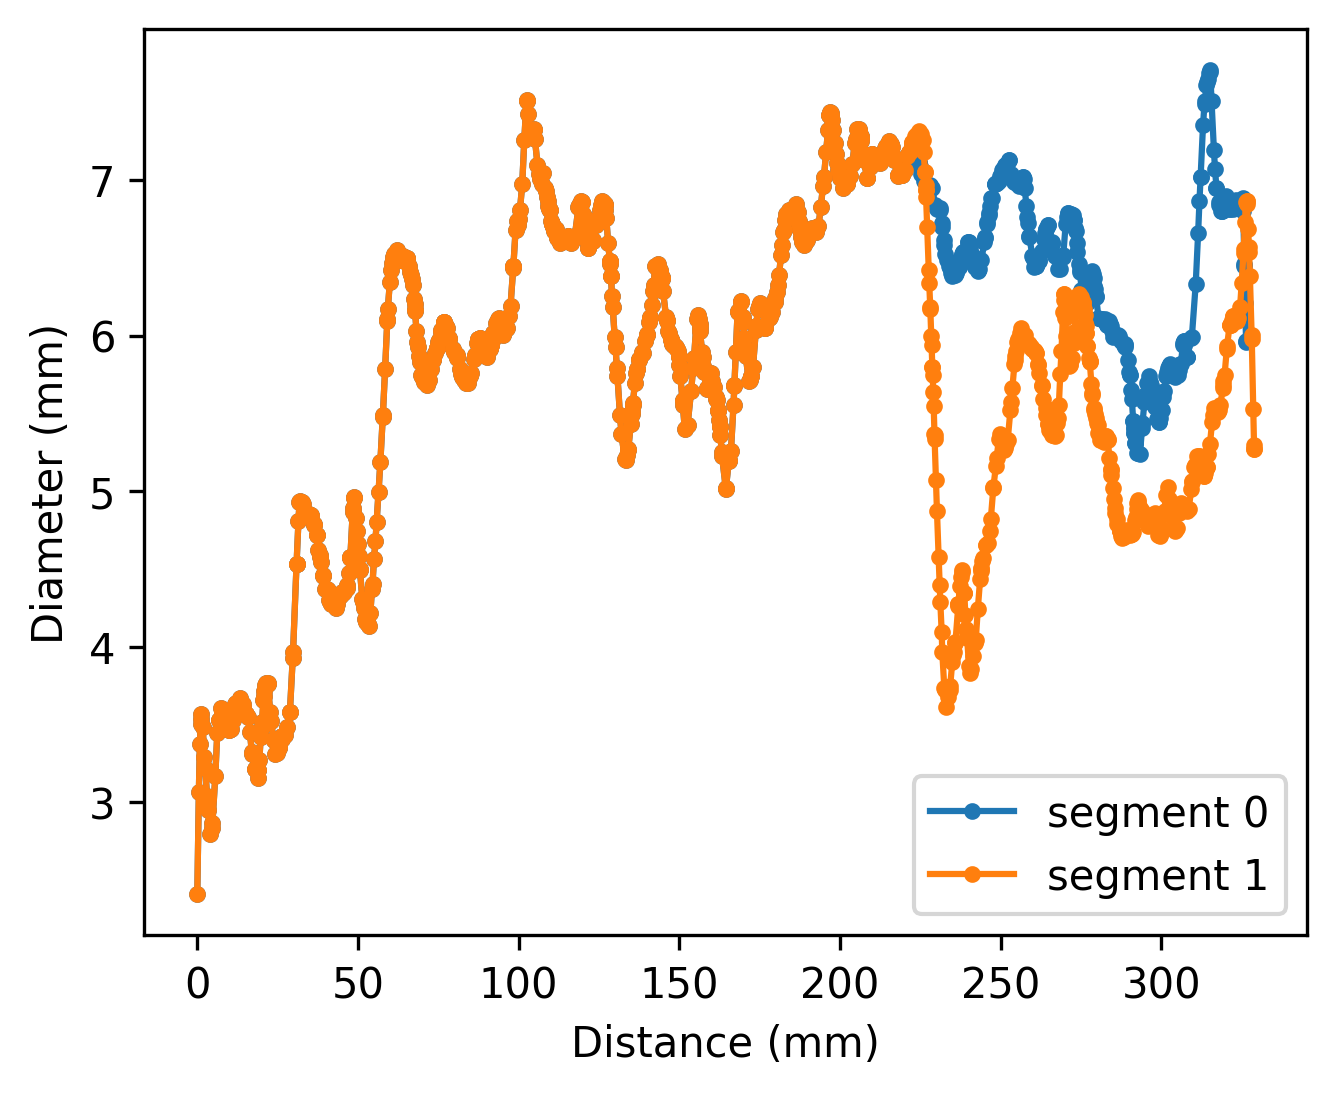

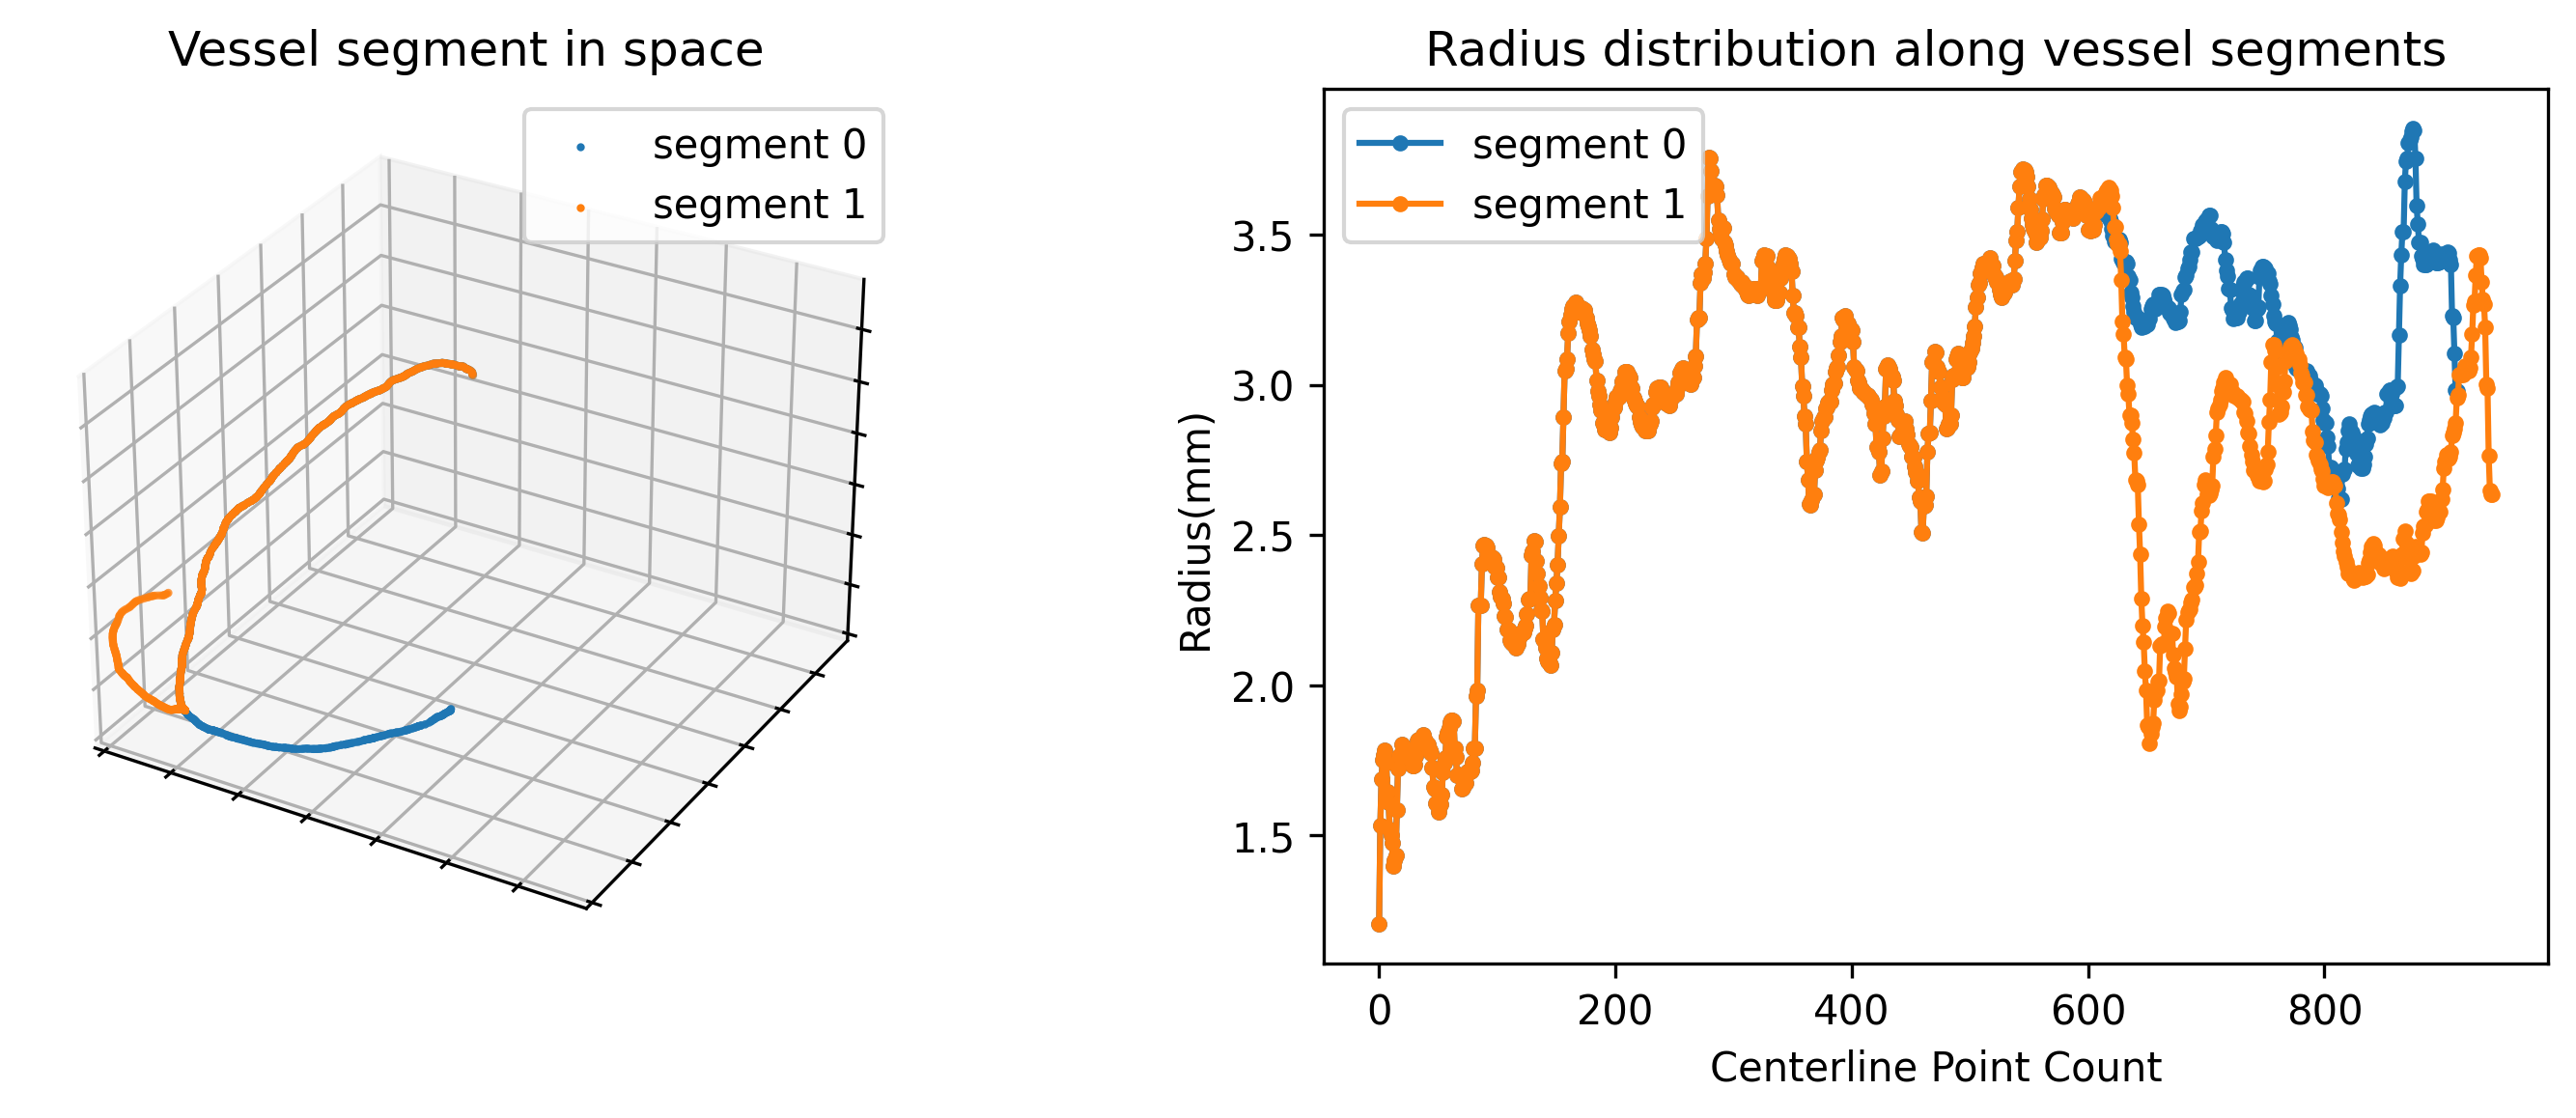

In [5]:

# -----------------------------------------------------------------
# Plotting

fig2 = plt.figure(figsize=(5, 4), dpi=300)
ax2 = fig2.add_subplot(111)
for segId in range(numSegments):
    segment = CenterlineData[CenterlineData['segId'] == segId]
    ax2.plot(segment['distance'],segment['diameter'],marker='.',label='segment {}'.format(segId))

ax2.set_xlabel('Distance (mm)')
ax2.set_ylabel('Diameter (mm)')
ax2.legend()

fig2_path = os.path.join(output_dir, fn_pattern + '-diameter_Plot.png')
#plt.savefig(fig2_path,dpi=600)


fig3 = plt.figure(figsize=(12,4), dpi=300)

ax1 = fig3.add_subplot(121, projection='3d')
ax2 = fig3.add_subplot(122)

for segId in range(numSegments):
    segment = segPointIds[segId]
    #ax.plot(range(len(segment)),radius[segment],marker='.',label='segment {}'.format(segId))
    ax1.scatter(points[segment,0],points[segment,1],points[segment,2],s=1,label='segment {}'.format(segId))
    ax2.plot(range(len(segment)),radius[segment],marker='.',label='segment {}'.format(segId))
    
ax1.set_xlim3d(-50,120)
ax1.set_ylim3d(-50,120)
ax1.set_zlim3d(-50,120)
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.set_zticklabels([])
ax1.title.set_text('Vessel segment in space')
ax1.legend()

ax2.title.set_text('Radius distribution along vessel segments')
ax2.set_xlabel('Centerline Point Count')
ax2.set_ylabel('Radius(mm)')    
ax2.legend()

#fig3_path = vmtkfolder + "sub-{}_".format(num) + side + "-artery-radius.png"
#plt.savefig(fig3_path)

#plt.show()

# Save data to csv
frames = []
for segId in range(numSegments):
    segment = segPointIds[segId]
    segData = pd.DataFrame({'pointId':segment,'segId':segId*np.ones(len(segment), dtype=int),'x':points[segment,0],'y':points[segment,1],'z':points[segment,2],'radius':radius[segment]})
    frames.append(segData)    
CenterlineData = pd.concat(frames)
print(CenterlineData)
#outDataframe = vmtkfolder + "sub-{}_".format(num) + side + "-artery-clData.csv"
#CenterlineData.to_csv(outDataframe,index=False)
